# Behavior Diffusion Modelling: Understanding Ownership Diffusion in Fantasy Sports using Neural Networks’ Prediction

Fantasy sports represent an emerging entertainment opportunity that better involves the fans in the respective sports. Through the aspect of the purchase and sale of players in the fantasy leagues, the behavior diffusion in virtual entertainment can be studied and predicted. In this project, the diffusion of the ownership of players in the Fantasy Premier League (FPL), will be explored with predictability evaluated through social influence (in terms of respective club popularity), market movements (in terms of player pricings in the fantasy leagues), player performance (in terms of player performance metrics) and game metrics (in terms of game difficulty and team strength).

# Social Network Analysis

In [46]:
!pip install --upgrade scipy

In [51]:
!pip install python-louvain

  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9414 sha256=228213b1552429437a17a6f935b961d1a2bae4d1579cbdc67b15b2d3ddf17c51
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\4d\7c\b6\79b198e4ec43f915fbdf967953d48b89a18893b12aa9df0ae2
Successfully built python-louvain


In [52]:
# Packages
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain
from scipy.stats import pearsonr

In [3]:
# Importing Data
df = pd.read_csv("fpl_hist_fanbase_merged.csv")
df.head()

,id_x,status,chance_of_playing_next_round,chance_of_playing_this_round,now_cost,now_cost_rank,now_cost_rank_type,cost_change_event,cost_change_event_fall,cost_change_start,...,expected_goal_involvements_momentum,team_points_avg,team_form_3,fanbase_x_points,fanbase_x_ownership,fanbase_x_transfer_pressure,influence_score,ownership_next,diffusion_target,diffusion_class
0,1,d,75.0,75.0,5.5,147,91,0,0,0,...,NaN,2.960000,NaN,0.0,0.04768,0.404528,0.050969,0.1,0.0,1
1,1,a,100.0,75.0,5.4,169,104,-1,1,-1,...,NaN,5.800000,NaN,0.0,0.04768,1.282883,0.050969,0.1,0.0,1
2,1,u,0.0,0.0,5.4,169,106,0,0,-1,...,0.0,6.178571,4.979524,0.0,0.04768,0.996369,0.050969,0.1,0.0,1
3,1,u,0.0,0.0,5.4,158,96,0,0,-1,...,0.0,7.866667,6.615079,0.0,0.04768,0.895319,0.050969,0.1,0.0,1
4,1,u,0.0,0.0,5.4,150,90,0,0,-1,...,0.0,9.066667,7.703968,0.0,0.04768,0.845195,0.050969,0.1,0.0,1


## Co-Transfer and Co-Ownership Network Analysis

In [4]:
# pivoting ownership deltas: rows=gw, cols=player_id, values = deltas
df = df.sort_values(['player_id','gw'])
df['ownership_delta'] = df.groupby('player_id')['ownership'].diff().fillna(0)

pivot = df.pivot(index='gw', columns='player_id', values='ownership_delta').fillna(0)
print(pivot.head())
players = pivot.columns.tolist()
print(players)

player_id  1    2    3    4    5    6    7    8    9    10   ...  795  796  \
gw                                                           ...             
1          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2          0.0 -0.7 -0.4  2.3  0.0  0.0  0.0  0.0 -0.3  0.0  ...  0.0  0.0   
3          0.0 -0.6 -0.5  0.9  0.0  0.1  0.0  0.0 -0.5  0.0  ...  0.0  0.0   
4          0.0 -0.1 -0.2 -0.6  0.0  0.1  0.0 -0.1 -0.2  0.0  ...  0.0  0.0   
5          0.0  0.1  5.0 -0.3  0.0  0.3  0.0  0.0  0.0  0.0  ...  0.0  0.0   

player_id  797  798  799  800  801  802  803  804  
gw                                                 
1          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
5          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 804 columns]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 1

In [5]:
# Getting correlation matrix for the pivotted deltas
corr_mat = pivot.corr(method='pearson')
#Addressing negative and NaN Values
corr_pos = corr_mat.clip(lower=0)
corr_pos = corr_pos.fillna(0)
corr_pos

player_id,1,2,3,4,5,6,7,8,9,10,...,795,796,797,798,799,800,801,802,803,804
player_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.000000,0.164943,0.031802,0.0,0.093371,0.000000,0.010375,0.575992,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.164943,1.000000,0.248750,0.0,0.000000,0.248941,0.000000,0.332041,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.031802,0.248750,1.000000,0.0,0.133710,0.451127,0.141606,0.442014,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
801,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
802,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# Setting edges threshold and building network
threshold = 0.5
edges = []
for i in corr_pos.index:
    for j in corr_pos.columns:
        if i >= j:   
            continue
        w = corr_pos.loc[i,j]
        if w > threshold:
            edges.append((i, j, w))

G = nx.Graph()
G.add_nodes_from(players)
G.add_weighted_edges_from(edges)

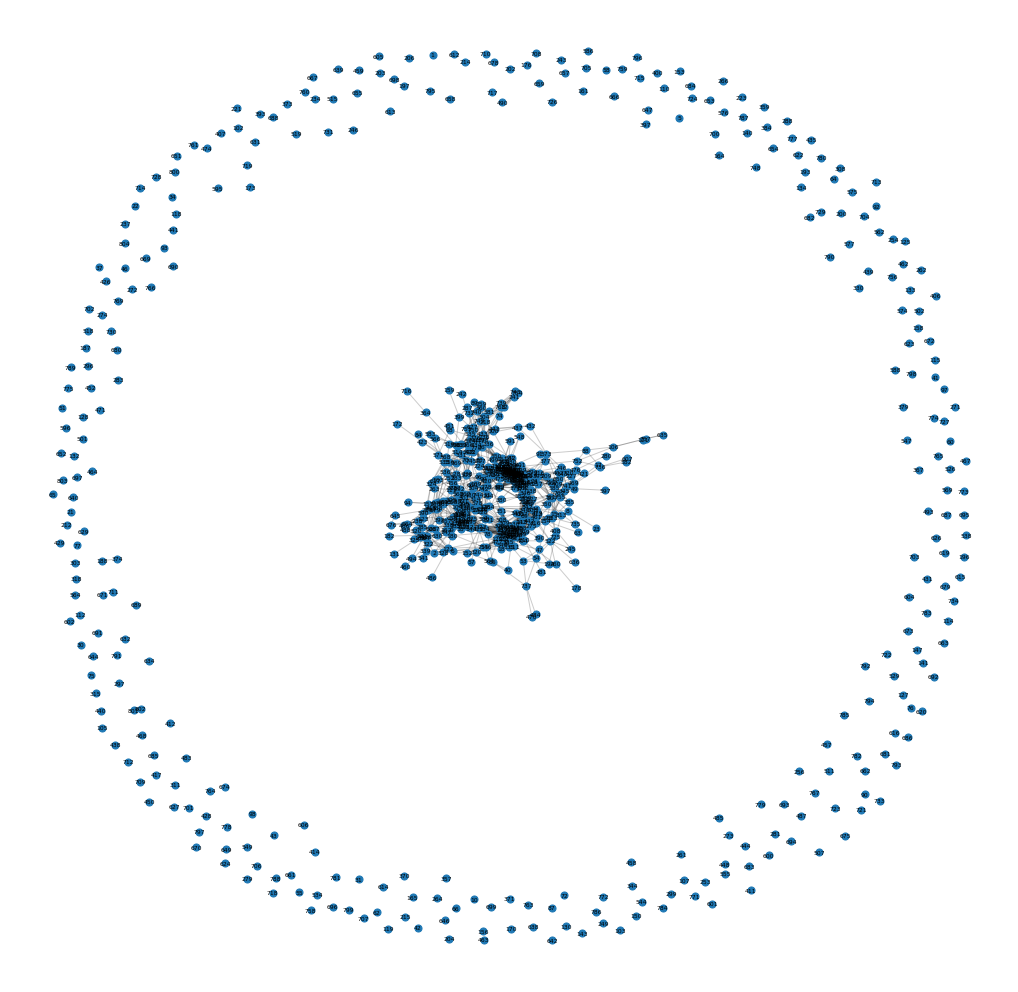

In [22]:
# Graphing Network
plt.figure(figsize=(18,18))
pos = nx.spring_layout(G, seed=42)  
nx.draw_networkx_nodes(G, pos, node_size=50)
nx.draw_networkx_edges(G, pos, alpha=0.2)
nx.draw_networkx_labels(G, pos, font_size=6)
plt.axis("off")
plt.show()

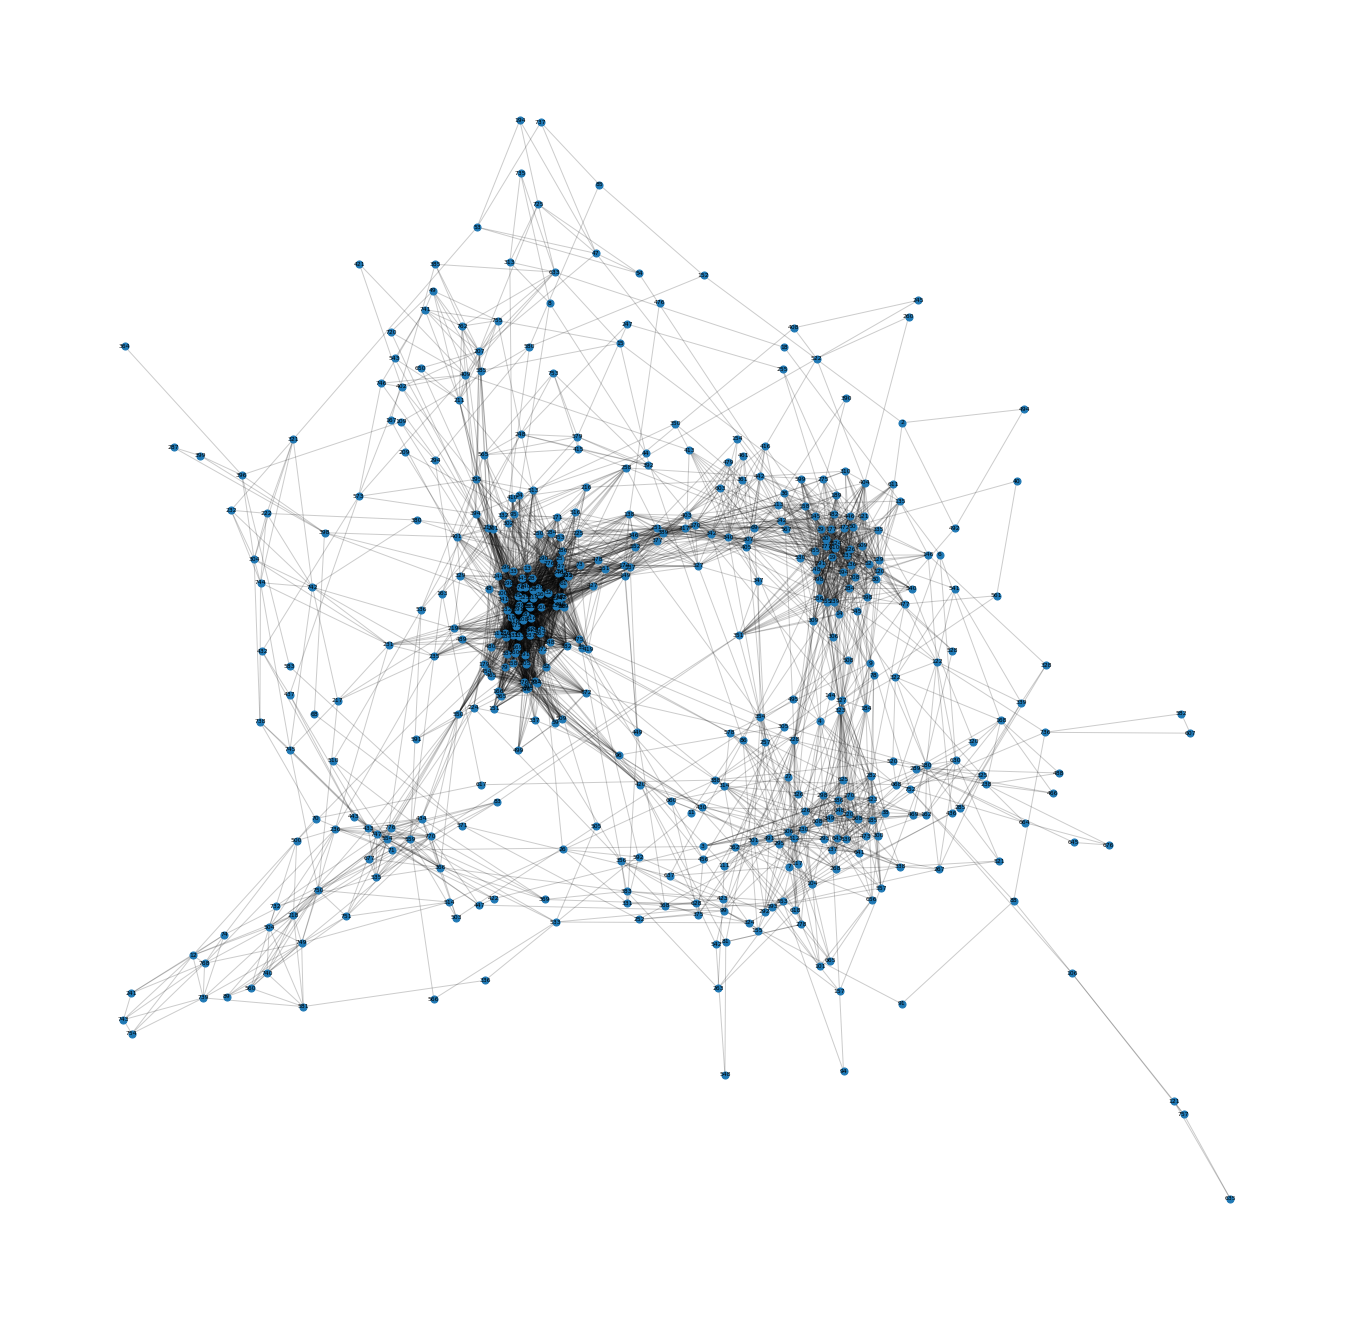

In [29]:
# Graphing only connected nodes
connected_nodes = [n for n, deg in G.degree() if deg > 1]
G_connected = G.subgraph(connected_nodes).copy()

plt.figure(figsize=(24,24))
pos = nx.spring_layout(G_connected, seed=42)  
nx.draw_networkx_nodes(G_connected, pos, node_size=50)
nx.draw_networkx_edges(G_connected, pos, alpha=0.2)
nx.draw_networkx_labels(G_connected, pos, font_size=6)
plt.axis("off")
plt.show()

## Structural Analysis

In [35]:
n = G.number_of_nodes()
m = G.number_of_edges()
density = nx.density(G)
avg_deg = sum(dict(G.degree()).values())/n
avg_clust = nx.average_clustering(G, weight='weight')
components = list(nx.connected_components(G))
print("The size of the network is such that it has", n, "players and", m, "connections")
print("The density of the network was", density, "with average density at", avg_deg)
print("The extent of the clustering in the network was", avg_clust)
print(components)

The size of the network is such that it has 804 players and 4727 connections
The density of the network was 0.014643470071807834 with average density at 11.75870646766169
The extent of the clustering in the network was 0.1875683637687135
[{1}, {2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 32, 33, 35, 36, 38, 39, 40, 44, 45, 47, 48, 49, 50, 52, 53, 54, 56, 57, 59, 61, 63, 67, 68, 69, 70, 71, 73, 74, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 91, 94, 95, 96, 99, 100, 101, 104, 106, 108, 109, 111, 113, 116, 117, 120, 121, 122, 123, 124, 126, 129, 131, 135, 136, 137, 138, 139, 142, 144, 145, 146, 148, 149, 151, 152, 154, 155, 157, 159, 160, 162, 163, 166, 167, 168, 169, 171, 172, 174, 175, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 189, 190, 191, 192, 194, 195, 198, 199, 201, 205, 207, 208, 209, 210, 211, 213, 216, 217, 218, 219, 220, 222, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 235, 236, 238, 239, 240, 241, 242, 244, 245, 247, 

## Relational Analysis

In [40]:
deg = dict(G.degree(weight=None))
print("Degree Centrality for co-transfering of players was", dict(sorted(deg.items(), key=lambda x: x[1], reverse=True)))
print()

strength = dict(G.degree(weight='weight'))
print("Magnitude of co-transfers was", dict(sorted(strength.items(), key=lambda x: x[1], reverse=True)))
print()

eig = nx.eigenvector_centrality_numpy(G, weight='weight')
print("The connection to highly co-transferred players", dict(sorted(eig.items(), key=lambda x: x[1], reverse=True)))
print()

btw = nx.betweenness_centrality(G, weight='weight', normalized=True)
print("The existence of players that bridge clusters was at", dict(sorted(btw.items(), key=lambda x: x[1], reverse=True)))
print()

closeness = nx.closeness_centrality(G, distance=None)  
print("The extent fof influence from a transfer was at", dict(sorted(closeness.items(), key=lambda x: x[1], reverse=True)))
print()



Degree Centrality for co-transfering of players was {589: 91, 116: 90, 181: 85, 191: 85, 108: 81, 381: 80, 45: 78, 175: 78, 229: 78, 240: 76, 378: 76, 418: 76, 353: 75, 445: 75, 363: 74, 424: 74, 525: 74, 546: 74, 531: 73, 316: 72, 319: 72, 25: 71, 276: 70, 343: 70, 352: 70, 16: 69, 333: 68, 28: 66, 160: 66, 348: 66, 341: 65, 587: 63, 186: 61, 32: 60, 169: 60, 286: 60, 29: 59, 382: 59, 56: 58, 67: 58, 124: 58, 139: 58, 213: 58, 244: 58, 269: 58, 312: 58, 496: 58, 183: 57, 372: 57, 360: 56, 13: 55, 82: 55, 61: 54, 73: 54, 391: 54, 497: 53, 532: 51, 387: 50, 192: 47, 425: 47, 545: 47, 33: 46, 190: 46, 524: 46, 177: 45, 195: 44, 290: 44, 334: 44, 365: 44, 376: 44, 563: 44, 20: 43, 100: 43, 198: 43, 205: 43, 517: 43, 199: 42, 233: 42, 50: 41, 142: 41, 226: 41, 291: 41, 498: 41, 551: 40, 239: 39, 358: 39, 69: 38, 307: 38, 174: 37, 472: 36, 478: 36, 148: 35, 149: 34, 201: 34, 584: 34, 610: 34, 79: 33, 208: 33, 210: 33, 284: 33, 340: 32, 19: 31, 39: 31, 453: 31, 537: 31, 35: 30, 48: 30, 251: 

## Dynamic Analysis

In [41]:
# build networks across GWs
W = 38
snap_graphs = {}
for t in sorted(df['gw'].unique())[W-1:]:
    window = df[df['gw'].between(t-W+1, t)]
    pivot_w = window.pivot(index='gw', columns='player_id', values='ownership_delta').fillna(0)
    corr = pivot_w.corr().clip(lower=0)
    edges = [(i,j,corr.loc[i,j]) for i in corr.index for j in corr.columns if i<j and corr.loc[i,j]>0.5]
    Gt = nx.Graph()
    Gt.add_nodes_from(pivot_w.columns.tolist())
    Gt.add_weighted_edges_from(edges)
    snap_graphs[t] = Gt

In [44]:
# Getting time series for centrality per player across GWs
records = []
for gw, Gt in snap_graphs.items():
    eig = nx.eigenvector_centrality_numpy(Gt, weight='weight')
    deg = dict(Gt.degree(weight='weight'))
    for pid in Gt.nodes():
        records.append({'gw':gw, 'player_id':pid, 'eig':eig.get(pid,0), 'strength':deg.get(pid,0)})
ts_df = pd.DataFrame(records)
ts_df

,gw,player_id,eig,strength
0,38,1,-2.578357e-19,0.000000
1,38,2,1.404364e-06,2.364754
2,38,3,3.361105e-06,4.875771
3,38,4,4.005676e-05,5.681645
4,38,5,4.910069e-20,0.000000
...,...,...,...,...
799,38,800,-9.893057e-19,0.000000
800,38,801,-5.875018e-19,0.000000
801,38,802,-3.787175e-19,0.000000
802,38,803,4.784700e-19,0.000000


## Community Detection

In [53]:
# Getting player presence in communities
partition = community_louvain.best_partition(G, weight='weight', resolution=1.0)
# Getting Communities
comm_df = pd.DataFrame.from_dict(partition, orient='index', columns=['community']).reset_index().rename(columns={'index':'player_id'})
comm_df['size'] = comm_df.groupby('community')['community'].transform('count')
comm_df

,player_id,community,size
0,1,0,1
1,2,1,93
2,3,1,93
3,4,1,93
4,5,2,1
...,...,...,...
799,800,332,1
800,801,333,1
801,802,334,1
802,803,335,1


In [57]:
# Community Sizes
comm_df.community.value_counts().sort_values(ascending=False)

1      93
7      72
8      61
6      61
9      46
       ..
334     1
335     1
328     1
318     1
35      1
Name: community, Length: 336, dtype: int64

## Saving Data

In [58]:
# Community Data
comm_df.to_csv("fpl_Network_Communities.csv", index=False)
